# Multi-model Fruit Ripeness Detection System



This notebook contains the model used to classify the ripeness levels of 3 fruits(Papaya,Mango & Banana) into 3 classes(Over Ripe, Ripe & Unripe). Our dataset was made by integrating several datasets from kaggle. A tranfer learning approach, using EfficientNetB7 keras application was used to develop the classification model. The performance of the model was checked using several evaluation metrices, such as F1-score, precision,evaluation matrix and recall. The outputs from the metrices indicated that the model acheived a high level of accuracy in classifying the ripeness levels of fruits. 

## Splitting the dataset 

In [71]:
import splitfolders 


input_folder = '/Users/admin/Downloads/DSGP/Fruit Dataset'


splitfolders.ratio(input_folder, output='/Users/admin/Downloads/DSGP/Fruit Dataset_S', 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None) 

Copying files: 6600 files [00:02, 2471.49 files/s]


## Importing Libraries 

In [109]:
import matplotlib.pyplot as plt 
import numpy as np 
import pathlib
import os
import PIL
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Reshape, Flatten, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

In [110]:
train_p = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/train'
valid_p = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/val'
test_p  = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/test'

## Initialize Image Size

In [111]:
img_size = (240,240)

## Initializing  training, validationg & testing data

In [112]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_p,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=img_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_p,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=img_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_p ,
    validation_split=None,
    subset=None,
    shuffle=False,
    batch_size=32,
    image_size=img_size
)

class_names = train_ds.class_names
print(class_names)

Found 5280 files belonging to 3 classes.
Found 1320 files belonging to 3 classes.
Found 660 files belonging to 3 classes.
['Over Ripe', 'Ripe', 'Unripe']


## Plotting Images with Labels

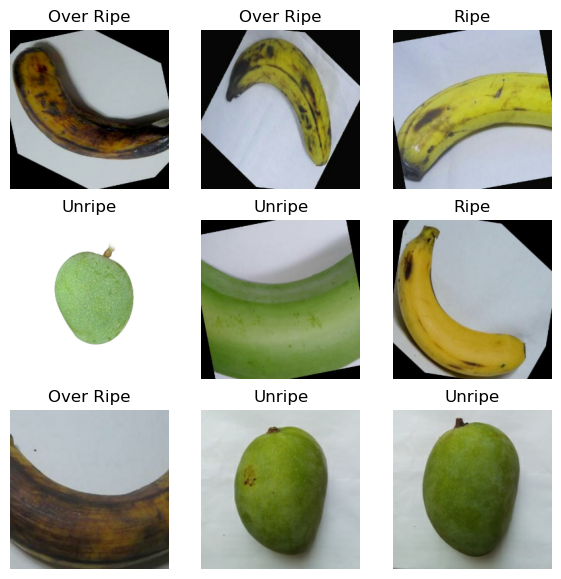

In [113]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

## Data Augmentation , Normalization & shuffling training dataset

In [114]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
# ])

# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# train_ds = train_ds.shuffle(buffer_size=1000)

In [115]:
no_classes = 3
input_shape = (240,240,3)

## Importing model to implement Tranfer Learning

In [116]:
efficientnet_model = Sequential()

pretrained_model = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling="avg",
    classes=no_classes
)

In [117]:
pretrained_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 rescaling_16 (Rescaling)    (None, 240, 240, 3)          0         ['input_9[0][0]']             
                                                                                                  
 normalization_8 (Normaliza  (None, 240, 240, 3)          7         ['rescaling_16[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_17 (Rescaling)    (None, 240, 240, 3)          0         ['normalization_8

## Freezing layers in the EfficientNetB7

In [118]:
for layer in pretrained_model.layers[:-5]:
    layer.trainable = False

In [119]:
for layer in pretrained_model.layers:
    print(layer.name, layer.trainable)

input_9 False
rescaling_16 False
normalization_8 False
rescaling_17 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False

## Making the classification model

In [120]:
efficientnet_model.add(pretrained_model)
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(256, activation='relu'))
efficientnet_model.add(Dropout(0.3))
efficientnet_model.add(Dense(128, activation='relu'))
efficientnet_model.add(Dropout(0.3))
efficientnet_model.add(Dense(64, activation='relu'))
efficientnet_model.add(Dropout(0.3))
efficientnet_model.add(Dense(32, activation='relu'))
efficientnet_model.add(Dropout(0.3))

## Compiling the model

In [121]:
efficientnet_model.compile(
    optimizer= LegacyAdam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

python(9323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9324) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


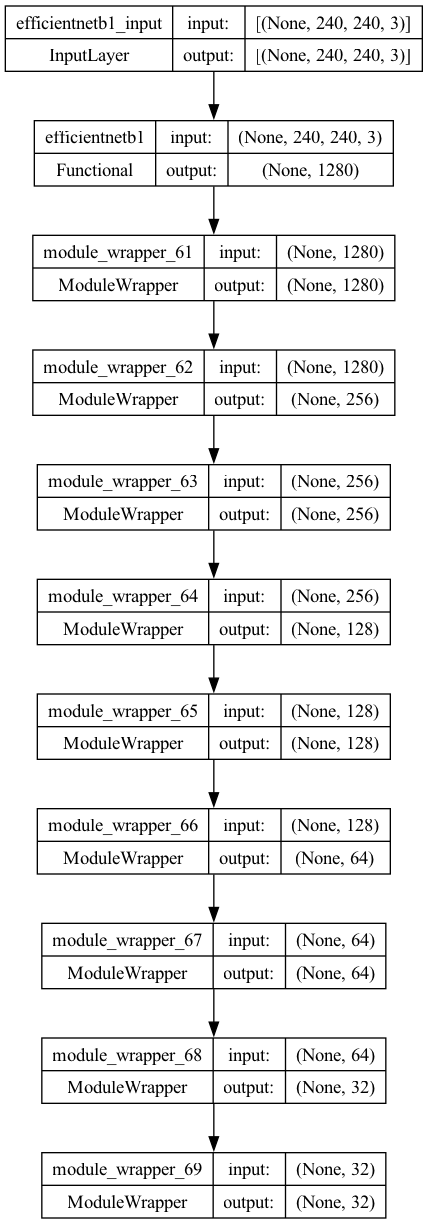

In [122]:
from tensorflow.keras.utils import plot_model

plot_model(efficientnet_model, to_file='model_eff.png',show_shapes=True, show_layer_names=True)

In [123]:
from keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1)
# model_checkp =  ModelCheckpoint('best_model_ripeness_classification.h5', monitor='val_loss', 
#                                 verbose=1, save_best_only=True)

history = efficientnet_model.fit(train_ds, validation_data = val_ds,
          epochs = 30, batch_size = 32, callbacks = [early_stopping])

Epoch 1/30
165/165 [==============================] - 46s 228ms/step - loss: 6.2842 - accuracy: 0.4375 - val_loss: 5.4420 - val_accuracy: 0.5508
Epoch 2/30
165/165 [==============================] - 29s 171ms/step - loss: 3.7037 - accuracy: 0.3271 - val_loss: 3.4447 - val_accuracy: 0.8189
Epoch 3/30
165/165 [==============================] - 28s 169ms/step - loss: 3.4017 - accuracy: 0.2614 - val_loss: 3.4631 - val_accuracy: 0.6091
Epoch 4/30
165/165 [==============================] - 29s 173ms/step - loss: 3.4464 - accuracy: 0.2583 - val_loss: 3.4657 - val_accuracy: 0.4742
Epoch 5/30
165/165 [==============================] - 28s 166ms/step - loss: 3.4559 - accuracy: 0.2585 - val_loss: 3.4657 - val_accuracy: 0.4758
Epoch 6/30
165/165 [==============================] - 28s 169ms/step - loss: 3.4533 - accuracy: 0.2604 - val_loss: 3.4657 - val_accuracy: 0.4758
Epoch 7/30
165/165 [==============================] - 28s 169ms/step - loss: 3.4530 - accuracy: 0.2508 - val_loss: 3.4657 - val_ac